# Project 3 part 1
Work flow: Feature engineering, Features selection by linear model, *Polynomial Logistic Regression*, GAN (for **Result Enhancing**)

Author: ZHAO JUNDA

## Data loading

In [ ]:
# 导入必要的包
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))# Project 3 part 3
Work flow: LightGBM (final model)

Author: HE HAOKAI

In [2]:
# 导入必要的包
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score


from sklearn import datasets


from sklearn.preprocessing import LabelEncoder

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

In [227]:
import pandas as pd
import numpy as np
import scipy

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import glmnet as gln

from tqdm.notebook import tqdm # a python package that provides progress bars for iterables
from operator import itemgetter
from itertools import combinations

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [529]:
#导入数据
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')


In [530]:
# 检查train data中的数据类型
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [531]:
# 编码种类不超过2的分类变量
le = LabelEncoder()
le_count = 0
 
# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [532]:
#处理性别变量
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)
 
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [533]:
targ = app_train['TARGET'] #save the column "TARGET"
 
# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
 
# Add the target back to the train data
app_train['TARGET'] = targ
 
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## forward step selection

In [ ]:
# Even though we found some null data in the train data, we can still use correlations to select appropriate variables
# Find correlations beween variables with the target 
# and rank them in order to pick up variables relatively highly related to the response

correlations = app_train.corr()['TARGET'].sort_values()

In [ ]:
print('Variables with TOP 15 Positive Correlation coefficient:\n', correlations.tail(15))
print('\nVariables with TOP 15 Negative Correlation coefficient:\n', correlations.head(15))

In [ ]:
list(correlations.head(15).index)+list(correlations.tail(15).index)

In [ ]:
poly_features = app_train[list(correlations.head(15).index)+list(correlations.tail(15).index)]
poly_features_test = app_test[list(correlations.head(15).index)+list(correlations.tail(15).index)[:-1]]
# To avoid those null data affect the regression model, we need to replace them with appropriate values    
# We adopt the function ---- imputer to do that
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
 
# Similarly, we leave the column "TARGET" unaffected    
poly_target = poly_features['TARGET']
poly_features_new = poly_features.drop(columns = ['TARGET'])
 
# impute missing values in both train and test data
poly_features_new = imputer.fit_transform(poly_features_new)
poly_features_test_new = imputer.transform(poly_features_test)

In [ ]:
train1=poly_features_new
train1=pd.DataFrame(train1,columns=list(correlations.head(15).index)+list(correlations.tail(15).index)[:-1])
train1["TARGET"]=poly_target
test1=poly_features_test_new
test1=pd.DataFrame(test1,columns=list(correlations.head(15).index)+list(correlations.tail(15).index)[:-1])

In [ ]:
# call our best_subsets function
predictors = list(train1.columns)
predictors.remove('TARGET')

In [ ]:
def forward_step_select(df, predictors, response, max_features=len(predictors)):
    """
    Regresses response onto predictors using a forward step algorithm. Features are added based on minimum RSS.
    
    PARAMETERS
    -----------
    df : dataframe containing predictors and responses
    predictors : list of all possible model predictors
    response : list[variable] to regress onto predictors in df
    max_features : maximum number of features to use from predictors list
    
    RETURNS
    --------
    list of models with increasing number of features upto max_features
    
    """
    
    def process_linear_model(features):
        """
        Constructs Linear Model Regression of response onto features.
        """
        # Create design Matrix
        X = sm.add_constant(df[features])
        y = df[response]

        model = sm.OLS(y,X).fit()
        RSS = model.ssr
        return (model, RSS)

    def update_model(best_features, remaining_features):
        """
        Computes the RSS of possible new models and returns the model with the lowest RSS.
        """
        results = []
        
        for feature in remaining_features:
            results.append(process_linear_model(best_features + [feature]))
            
        # select model with the lowest RSS
        new_model = sorted(results, key= itemgetter(1)).pop(0)[0]
        new_features = list(new_model.params.index)[1:]
        
        return new_features, new_model
    
    # Create list to hold models, model features and the remaining features to test
    models = []
    best_features = []
    remaining_features = predictors
    
    while remaining_features and len(best_features) < max_features:
        
        # get the best new feature set from update_model
        new_features, new_model = update_model(best_features, remaining_features)
        # update the best features to include the one we just found
        best_features = new_features  
        # reduce the available features for the next round
        remaining_features =  [feature for feature in predictors if feature not in best_features]
        
        # append the new_features and model so we can compare models with different features later
        models.append((new_features,new_model))
        
    return models

In [ ]:
# Call our forward step function
# set up inputs
predictors = list(train1.columns)
predictors.remove('TARGET')
# call forward_step_select
mods = forward_step_select(train1,predictors,['TARGET'],max_features=19)

In [ ]:
fwdmodel=mods[-1][1]

In [ ]:
X1=train1[mods[-1][0]]

In [ ]:
# Now that all of variables mentioned above are appropriate, we try to build a regression model
regr = skl_lm.LogisticRegression()
regr.fit(X1, poly_target)

In [ ]:
pred = regr.predict(X1)
cm_log = confusion_matrix(poly_target, pred)
cm_df = pd.DataFrame(cm_log.T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

In [ ]:
pred_p = regr.predict_proba(X1)
cm_df = pd.DataFrame({'True': poly_target, 'Pred': pred_p[:,1] > .2})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(poly_target, pred_p[:,1] > .2))

In [ ]:
# obtain the final result
pred3 =regr.predict_proba(test1[mods[-1][0]])

In [ ]:
result = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': pred3[:,1]})
result

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 2)
# Train the polynomial features
poly_transformer.fit(train1[mods[-1][0]])
 
# Transform the features
poly_features_trans = poly_transformer.transform(train1[mods[-1][0]])
poly_features_test_trans = poly_transformer.transform(test1[mods[-1][0]])
print('Polynomial Features shape: ', poly_features_trans.shape)
poly_transformer.get_feature_names(input_features = mods[-1][0])[:20]

In [ ]:
poly_features_DF = pd.DataFrame(poly_features_trans, 
                             columns = poly_transformer.get_feature_names(mods[-1][0]))

poly_features_test_DF = pd.DataFrame(poly_features_test_trans, 
                                  columns = poly_transformer.get_feature_names(mods[-1][0]))
 
# Add the target into the data
poly_features_DF['TARGET'] = poly_target

In [ ]:
# Find the correlations with the target and print them
correlations_2 = poly_features_DF.corr()['TARGET'].sort_values()

In [ ]:
ind=list(correlations_2.head(15).index)+list(correlations_2.tail(15).index[:-2])

In [ ]:
# set up inputs
predictors = list(ind)
predictors.remove('TARGET')
# call forward_step_select
mods2 = forward_step_select(poly_features_DF,predictors,['TARGET'],max_features=15)

In [ ]:
regr2 = skl_lm.LogisticRegression()
regr2.fit(poly_features_DF[mods2[-1][0]], poly_target)

In [ ]:
pred4 =regr2.predict_proba(poly_features_test_DF[mods2[-1][0]])

In [ ]:
result = pd.DataFrame({'SK_ID_CURR': app_test['SK_ID_CURR'], 'TARGET': pred4[:,1]})
result

In [ ]:
result.to_csv('resul.csv', index=False)

## GAN applying 

In [534]:
test=app_test

In [537]:
newdata=pd.read_csv("GAN_generated.csv")

In [538]:
dat=pd.DataFrame(newdata.iloc[:,1:])

In [539]:
tt=pd.Series(1,index=range(0,len(dat)))

In [540]:
newdata["TARGET"]=tt

In [541]:
data=dat.drop(columns=['CREDIT_ACTIVE_Active'])

In [590]:
train=app_train[data.columns]

In [593]:
train["TARGET"]=app_train["TARGET"]

/var/folders/79/hqvyyq2d0jjg47twwbkkn3vw0000gn/T/ipykernel_28271/2537677286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["TARGET"]=app_train["TARGET"]


In [594]:
data.index=range(307510,607510)

In [595]:
min_max_scaler = preprocessing.MinMaxScaler()
minmax_x1 = min_max_scaler.fit_transform(train)

In [596]:
train=pd.DataFrame(minmax_x1,columns=train.columns)

In [597]:
min_max_scaler = preprocessing.MinMaxScaler()
minmax_x = min_max_scaler.fit_transform(test)

In [598]:
test=pd.DataFrame(minmax_x,columns=test.columns)

In [549]:
##store the original data
app_test1=app_test

In [550]:
app_test=test

In [599]:
train2=pd.concat([train,data[307510:309510]],axis=0)

In [601]:
poly_features = train2
poly_features_test = app_test[train2.columns[:-1]]

In [602]:
# To avoid those null data affect the regression model, we need to replace them with appropriate values    
# We adopt the function ---- imputer to do that
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')
 
# Similarly, we leave the column "TARGET" unaffected    
poly_target = poly_features['TARGET']
poly_features_new = poly_features.drop(columns = ['TARGET'])
 
# impute missing values in both train and test data
poly_features_new = imputer.fit_transform(poly_features_new)
poly_features_test_new = imputer.transform(poly_features_test)
 
from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [603]:
poly_features_new=pd.DataFrame(poly_features_new,columns=poly_features.drop(columns = ['TARGET']).columns)

In [604]:
poly_features_test_new =pd.DataFrame(poly_features_test_new,columns=poly_features.drop(columns = ['TARGET']).columns)

In [605]:
# Train the polynomial features
poly_transformer.fit(poly_features_new)
 
# Transform the features
poly_features_trans = poly_transformer.transform(poly_features_new)
poly_features_test_trans = poly_transformer.transform(poly_features_test_new)
print('Polynomial Features shape: ', poly_features_trans.shape)
poly_transformer.get_feature_names(input_features = poly_features_new.columns )

Polynomial Features shape:  (307511, 220)


/Users/zjd/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'DAYS_ID_PUBLISH',
 'AMT_ANNUITY',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_EMPLOYED',
 'EXT_SOURCE_1 AMT_CREDIT',
 'EXT_SOURCE_1 AMT_GOODS_PRICE',
 'EXT_SOURCE_1 DAYS_ID_PUBLISH',
 'EXT_SOURCE_1 AMT_ANNUITY',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_EMPLOYED',
 'EXT_SOURCE_2 AMT_CREDIT',
 'EXT_SOURCE_2 AMT_GOODS_PRICE',
 'EXT_SOURCE_2 DAYS_ID_PUBLISH',
 'EXT_SOURCE_2 AMT_ANNUITY',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_EMPLOYED',
 'EXT_SOURCE_3 AMT_CREDIT',
 'EXT_SOURCE_3 AMT_GOODS_PRICE',
 'EXT_SOURCE_3 DAYS_ID_PUBLISH',
 'EXT_SOURCE_3 AMT_ANNUITY',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH DAYS_EMPLOYED',
 'DAYS_BIRTH AMT_CREDIT',
 'DAYS_BIRTH AMT_GOODS_PRICE',
 'DAYS_BIRTH DAYS_ID_PUBLISH',
 'DAYS_BIRTH

In [606]:
poly_features_DF = pd.DataFrame(poly_features_trans, 
                             columns = poly_transformer.get_feature_names(poly_features_new.columns))

poly_features_test_DF = pd.DataFrame(poly_features_test_trans, 
                                  columns = poly_transformer.get_feature_names(poly_features_new.columns))

In [607]:
targg=pd.DataFrame(poly_target,columns=["TARGET"])

In [608]:
a=targg.reset_index()
b=poly_features_DF.reset_index()
poly_features_DF=pd.concat([a,b],axis=1)

In [609]:
poly_features_DF=poly_features_DF.drop(columns=["index"])

In [610]:
 # Find the correlations with the target and print them
correlations_2 = poly_features_DF.corr()['TARGET'].sort_values()
 
print(correlations_2.head(10))
print(correlations_2.tail(10))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193927
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.188948
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172243
EXT_SOURCE_1 EXT_SOURCE_2                -0.166046
EXT_SOURCE_1 EXT_SOURCE_3                -0.163492
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156603
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150615
Name: TARGET, dtype: float64
DAYS_BIRTH^2 AMT_ANNUITY        0.050211
DAYS_ID_PUBLISH                 0.051457
DAYS_BIRTH DAYS_ID_PUBLISH^2    0.074381
DAYS_BIRTH^3                    0.075131
DAYS_BIRTH^2                    0.077783
DAYS_BIRTH                      0.078239
DAYS_BIRTH^2 DAYS_ID_PUBLISH    0.080935
DAYS_BIRTH DAYS_ID_PUBLISH      0.082665
TARGET                          1.000000
1                                    NaN
Name: TARGET, dtype: float64


In [611]:
# Only choose variables with a correlation coefficient more than 0.150000 
try_set = correlations_2.head(10)._stat_axis.values.tolist() + correlations_2.tail(10)._stat_axis.values.tolist()
try_set

['EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH^2 AMT_ANNUITY',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH DAYS_ID_PUBLISH^2',
 'DAYS_BIRTH^3',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH',
 'DAYS_BIRTH^2 DAYS_ID_PUBLISH',
 'DAYS_BIRTH DAYS_ID_PUBLISH',
 'TARGET',
 '1']

In [612]:
try_set2=try_set[:-2]
try_set2

['EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH^2 AMT_ANNUITY',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH DAYS_ID_PUBLISH^2',
 'DAYS_BIRTH^3',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH',
 'DAYS_BIRTH^2 DAYS_ID_PUBLISH',
 'DAYS_BIRTH DAYS_ID_PUBLISH']

In [613]:
pp=poly_target.tolist()

In [614]:
#calculate the significance of candidates of new features
Version_2 = sm.add_constant(poly_features_DF[try_set2])
est2 = sm.Logit(pp , Version_2).fit()
est2.summary().tables[1]

/Users/zjd/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.255896
         Iterations 8


,coef,std err,z,P>|z|,[0.025,0.975]
const,-1.0786,0.117,-9.201,0.000,-1.308,-0.849
EXT_SOURCE_2 EXT_SOURCE_3,-2.7500,0.742,-3.706,0.000,-4.205,-1.295
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,2.0042,0.588,3.407,0.001,0.851,3.157
EXT_SOURCE_2^2 EXT_SOURCE_3,0.3462,0.480,0.722,0.470,-0.594,1.286
EXT_SOURCE_2 EXT_SOURCE_3^2,0.9326,0.480,1.945,0.052,-0.007,1.873
EXT_SOURCE_1 EXT_SOURCE_2,-1.9371,0.440,-4.407,0.000,-2.799,-1.076
EXT_SOURCE_1 EXT_SOURCE_3,-1.9737,0.431,-4.578,0.000,-2.819,-1.129
EXT_SOURCE_2,-0.5584,0.181,-3.089,0.002,-0.913,-0.204
EXT_SOURCE_1 EXT_SOURCE_2^2,-0.3976,0.502,-0.791,0.429,-1.382,0.587
EXT_SOURCE_3,-1.0030,0.188,-5.326,0.000,-1.372,-0.634


In [615]:
#挑选出有用的参数并再计算验证
Version_3=poly_features_DF[[
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH^2 AMT_ANNUITY',
 'DAYS_BIRTH^3',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH',
 'DAYS_BIRTH^2 DAYS_ID_PUBLISH',
 'DAYS_BIRTH DAYS_ID_PUBLISH']]
est3 = sm.Logit(pp , Version_3).fit()
est3.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.256055
         Iterations 8


,coef,std err,z,P>|z|,[0.025,0.975]
EXT_SOURCE_1 EXT_SOURCE_2,-1.5091,0.150,-10.084,0.000,-1.802,-1.216
EXT_SOURCE_1 EXT_SOURCE_3,-2.4454,0.245,-9.974,0.000,-2.926,-1.965
EXT_SOURCE_2,-1.4177,0.076,-18.646,0.000,-1.567,-1.269
EXT_SOURCE_3,-1.8006,0.084,-21.401,0.000,-1.966,-1.636
EXT_SOURCE_1 EXT_SOURCE_3^2,1.2692,0.243,5.216,0.000,0.792,1.746
DAYS_BIRTH^2 AMT_ANNUITY,1.2303,0.281,4.377,0.000,0.679,1.781
DAYS_BIRTH^3,-4.7516,0.447,-10.639,0.000,-5.627,-3.876
DAYS_BIRTH^2,5.7845,0.573,10.094,0.000,4.661,6.908
DAYS_BIRTH,-1.8667,0.269,-6.937,0.000,-2.394,-1.339
DAYS_BIRTH^2 DAYS_ID_PUBLISH,-0.7178,0.427,-1.680,0.093,-1.555,0.119


In [616]:
Version_3=poly_features_DF[['EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH^2 AMT_ANNUITY',
 'DAYS_BIRTH^3',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH',
 'DAYS_BIRTH^2 DAYS_ID_PUBLISH',
 'DAYS_BIRTH DAYS_ID_PUBLISH']]

In [617]:
regr2 = skl_lm.LogisticRegression()
regr2.fit(Version_3, poly_target)

pred2 = regr2.predict(Version_3)
cm_log2 = confusion_matrix(poly_target, pred2)
cm_df2 = pd.DataFrame(cm_log2.T, index=regr2.classes_,
                     columns=regr2.classes_)
cm_df2.index.name = 'Predicted'
cm_df2.columns.name = 'True'

/Users/zjd/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [618]:
# set 0.2 as a standard to classify the prediction
pred_p2 = regr2.predict_proba(Version_3)
cm_df2 = pd.DataFrame({'True': poly_target, 'Pred': pred_p2[:,1] > .2})
cm_df2.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df2.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(poly_target, pred_p2[:,1] > .2))

Pred      No    Yes
True               
0.0   268902  13784
1.0    19852   4973
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94    282686
         1.0       0.27      0.20      0.23     24825

    accuracy                           0.89    307511
   macro avg       0.60      0.58      0.58    307511
weighted avg       0.88      0.89      0.88    307511



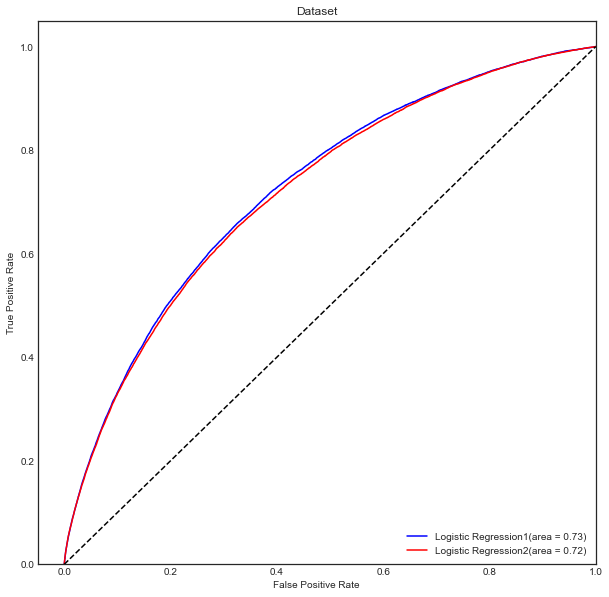

In [619]:
# ROC curve of Logistic Regression2
false_pos_rate2, true_pos_rate2, _ = roc_curve(poly_target, pred_p2[:,1])
roc_auc2 = auc(false_pos_rate2, true_pos_rate2)


fig, (ax1) = plt.subplots(1,  figsize=(10,10))
ax1.plot(false_pos_rate2, true_pos_rate2, label='Logistic Regression2(area = %0.2f)' % roc_auc2, color='r')
ax1.set_title('Dataset')



for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

In [622]:
# obtain the final result
pred3 =regr2.predict_proba(poly_features_test_DF[['EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH^2 AMT_ANNUITY',
 'DAYS_BIRTH^3',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH',
 'DAYS_BIRTH^2 DAYS_ID_PUBLISH',
 'DAYS_BIRTH DAYS_ID_PUBLISH']])


In [623]:
result = pd.DataFrame({'SK_ID_CURR': app_test1['SK_ID_CURR'], 'TARGET': pred3[:,1]})

result

       SK_ID_CURR    TARGET
0          100001  0.052618
1          100005  0.122956
2          100013  0.028098
3          100028  0.050555
4          100038  0.125180
...           ...       ...
48739      456221  0.028816
48740      456222  0.042620
48741      456223  0.066972
48742      456224  0.093298
48743      456250  0.132712

[48744 rows x 2 columns]

In [624]:
# save the data for submission
result.to_csv('resultfinal.csv', index=False)